In [87]:
import pandas as pd
import sys
# import warnings
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn import mixture
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from statsmodels.tools import add_constant
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import ConstantKernel as C
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, RationalQuadratic, DotProduct
import statsmodels.api as sm
sns.set(style="ticks")
import random
# import tensorflow as tf
from matplotlib import pyplot as plt
# import GPflow
# import george
# george.__version__
# from george import kernels
import os

%matplotlib inline

# warnings.filterwarnings('ignore', category=FutureWarning)

<h3> Define functions needed for Gaussian process model </h3>

In [3]:
def get_filenames(folderpath):
   filenames = os.listdir(folderpath)
   return filenames

In [4]:
"""Reading CO2 hourly Data for 6/19 in Boston"""

def read_csv_file(file):
    df = pd.read_csv(file)
    return df

In [5]:
"""
Reads in multiple csv files given list of filenames/paths
Returns dataframe containing combined concatenated file contents
"""

def read_multiple_csvs(filename_list, local_path):

    DFlist = []

    for i in range(0,6):
        DF = pd.read_csv(local_path + filename_list[i], engine='python')
        # hold = DF["Sample Collection Start Time"]
        # DF["Sample Collection Start Time"] = hold + 24*i
        DFlist.append(DF)

    big_dataframe = pd.concat(DFlist)
    
    return big_dataframe

In [6]:
"""Cleans the times to a parsable format"""

def clean_time(col_name):
    times = []
    time = list(df[col_name])
    for i in range(len(time)):
        times.append(float(time[i][:2]))
    df[col_name] = times #could cause error
    return df

In [8]:
"""Cleans the times to a parsable format for multiple days in a row"""
def clean_time_multiple(DF, col_name):
    
    times = []
    time = list(DF[col_name])
    
    prev_T = float(time[0][:2])
    day = 0
    
    for i in range(len(time)):
        T = float(time[i][:2])
        if prev_T > T:
            day += 1
        times.append(T + day*24)
        prev_T = T
    
    DF[col_name] = times
    
    return DF

In [9]:
"""Splits dataframe into train and test data"""
def split_train_test(df):
    train, test = train_test_split(df, test_size=.30, random_state=0)
    x_train = train["Sample Collection Start Time"]
    y_train = train["Measure Value"]
    x_test = test["Sample Collection Start Time"]
    y_test = test["Measure Value"]
    return x_train, y_train, x_test, y_test

In [10]:
"""Plots level of air pollutant with respect to time for x train and y train"""
def plot_original(x_train, y_train):
    plt.scatter(x_train, y_train)
    plt.ylabel("Measure Value")
    plt.xlabel("Time Occurred")
    plt.title("Boston CO2 level on 6/19")
    plt.show()

In [81]:
"""
Creates Gaussian model, computs r squarred, MSE and log liklihood
Given x_train, y_train, x_test, and y_test data, and numerical alpha value
Prints train and test R^2

"""

def simple_gaussian(x_train, y_train, x_test, y_test, alpha):
    
    train_size = x_train.shape[0]
    test_size = x_test.shape[0]
    
    kern = RBF(length_scale = 1)
    
    gp = GaussianProcessRegressor(kernel=kern, alpha=alpha, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=False, copy_X_train=False, random_state=None)
    gp.fit(x_train.reshape(train_size, 1), y_train.reshape(train_size, 1))

    y_train_pred, sigma_train = gp.predict(x_train.reshape(train_size, 1), return_std=True)
    y_test_pred, sigma_test = gp.predict(x_test.reshape(test_size, 1), return_std=True)

    # get R^2
    r2 = gp.score(x_train.reshape(train_size, 1), y_train.reshape(train_size, 1))
    r2_t = gp.score(x_test.reshape(test_size, 1), y_test.reshape(test_size, 1))

    # get MSE measurements
    MSE_test = np.mean((y_test_pred - y_test.reshape(test_size, 1))**2)
    MSE_train = np.mean((y_train_pred - y_train.reshape(train_size, 1))**2)

    # get log likelihood
    t = gp.log_marginal_likelihood()

    # calculate AIC
    AIC = 2*len(x_test) - 2*np.log(t)
    
    # print R^2 values
    print('mean squared error of train data with model = ' + str(MSE_train))
    print('mean squared error of test data with model = ' + str(MSE_test))
    print('Akaike information criterion = ' + str(AIC))
    print('log likelihood of model = ' + str(t))
    print('training R^2 value = ' + str(r2))
    print('testing R^2 value = ' + str(r2_t))
    
    return y_train_pred, y_test_pred, gp

In [53]:
"""Plots predicted y values for testing set"""
def plot_predictions(x_test, y_test, y_test_pred, x_label, y_label):
    plt.figure(figsize=(13,8))
    plt.plot(x_test, y_test, ".", color="r",)
    plt.scatter(x_test, y_test_pred)
    plt.xlabel(x_label)
    plt.title(y_label)
    plt.show()

<h3> Kaela and Annamira's Gaussian models: </h3>

<h3> Define filenames used </h3>

In [12]:
filepath_annamira = r'/Users/Annamira/Documents/GitHub/TRiCAM_BostonAQ/Boston_AQ_Hourly/'

CO_filenames = ['boston_06_19_CO.csv', 'boston_06_20_CO.csv', 'boston_06_21_CO.csv',
             'boston_06_22_CO.csv', 'boston_06_23_CO.csv', 'boston_06_24_CO.csv']

CO_6_19 = 'boston_06_19_CO.csv'

<h3> Gaussian process (six days in a row) </h3>

In [59]:
pollutants = ['CO', 'SO', 'NO', 'OZO', 'PM']
local_path = 'Boston_AQ_Hourly/'

alphas = [0.000888, 0.00000001, 0.000001, 0.00001, 0.000588]

x_label = 'Time'
y_labels = pollutants

mean squared error of train data with model = 0.00170942185859
mean squared error of test data with model = 0.00186829848785
Akaike information criterion = 285.927202267
log likelihood of model = 418.383663375
training R^2 value = 0.65685162851
testing R^2 value = 0.493193732085


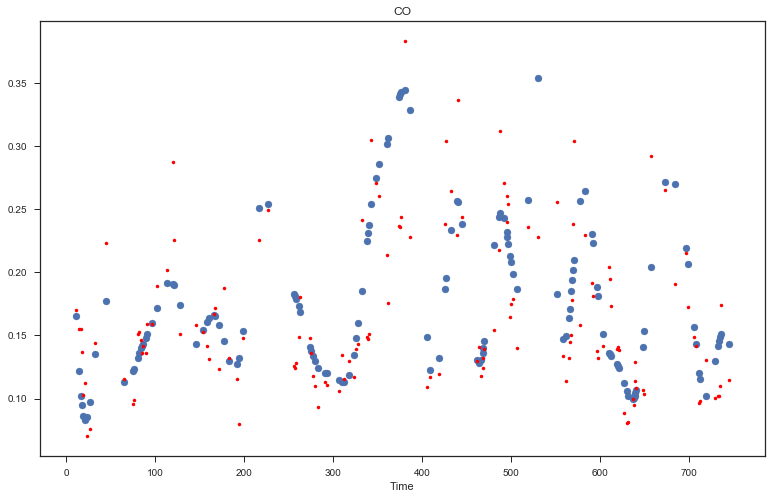

UserWarning: Predicted variances smaller than 0. Setting those variances to 0.

In [88]:
for i in range(0,5):

    filenames = get_filenames(local_path + pollutants[i] + '/')

    DF = read_multiple_csvs(filenames, local_path + pollutants[i] + '/')

    DF = clean_time_multiple(DF, 'Sample Collection Start Time')

    x_train, y_train, x_test, y_test = split_train_test(DF)

    y_train_pred, y_test_pred, gp = simple_gaussian(x_train, y_train, x_test, y_test, alphas[i])

    plot_predictions(x_test, y_test, y_test_pred, x_label, y_labels[i])
